In [1]:
import pandas as pd
import numpy
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('ggplot')
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import joblib
from scipy.integrate import simps
from datetime import datetime
import sklearn.metrics as metrics
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.layers import Dropout
from keras.regularizers import l2
from keras import initializers

from xgboost import XGBClassifier

def norm_minimax(datos_train, datos_test=None, splits=True, mini=None, maxi=None):
    if (mini is None) and (maxi is None):
        maxi=(np.max(datos_train))
        mini=(np.min(datos_train))
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train, mini, maxi
    if (mini is not None) & (maxi is not None) & (splits==True):
        datos_train = (datos_train-mini)/(maxi-mini)
        datos_test = (datos_test-mini)/(maxi-mini)
        return datos_train, datos_test
    if (mini is not None) & (maxi is not None) & (splits==False):
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train
    print('Error de entradas en nomalizacion minimax')
    return -1

# calcular peso de clase para darselo al modelo
def pesos_clases(y_train, only_pos=False):
    cant_refa = 0
    cant_norefa = 0
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            cant_refa = cant_refa + 1
        else:
            cant_norefa = cant_norefa + 1
    total = cant_norefa + cant_refa
    porcentaje_refa = (cant_refa/total)*100
    print('Porcentaje de refacturas: %0.2f' % porcentaje_refa)
    weight_for_0 = (1 / cant_norefa)*(total)/2.0 
    weight_for_1 = ((1 / cant_refa)*(total)/2.0) #/2 #dividido 2 para que no haya tantos falsos positivos
    class_weight = {0: weight_for_0, 1: weight_for_1}
    initial_bias = np.log([cant_refa/cant_norefa])
    #weight = cant_norefa/cant_refa
    print('Peso de clase "0" (sin refactura): {:.2f}'.format(weight_for_0))
    print('Peso de clase "1" (con refactura): {:.2f}'.format(weight_for_1))
    print('Bias inicial: ',initial_bias)
    if only_pos==False:
        return weight_for_0, weight_for_1, initial_bias
    else:
        return weight_for_1

def curva_ROC(fpr, tpr, roc_auc):  
    # method I: plt
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--', color='RoyalBlue')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    #plt.savefig("ROC"  + ".jpg")
    plt.show()

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y, umbral=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Blues');
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    #plt.savefig("matriz_confusion"  + ".jpg")
    plt.show()
    #print (classification_report(y_test, pred_y))
    
def MOSTRAR_METRICAS(y_test, pred_y, umbral=None, beta=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    [TN, FP],[FN,TP] = confusion_matrix(y_test, pred_y)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2*recall*precision) / (recall + precision)
    g_mean = np.sqrt((TP / (TP + FN)) * (TN / (TN + FP)))
    print('Recall: %0.4f' % recall)
    print('Precision: %0.4f' % precision)
    print('F1-score: %0.4f' % f1_score)
    print('G-mean: %0.4f' % g_mean)
    if beta is not None:
        f_beta = (((1 + beta)**2) * recall * precision) / (((beta**2) * precision) + recall)
        print('F-measure: %0.4f' % f_beta)
        return recall, precision, f1_score, g_mean, f_beta
    return recall, precision, f1_score, g_mean
        
def AUCM_PLOT(archivo):
    # Calculo de porcentajes
    porc_TD = numpy.arange(0, 1.01, 0.01)
    porc_TR = numpy.arange(0, 1.01, 0.01)
    j = 0
    maximo = 0
    limite_pasado = False
    for umbral in numpy.arange(0, 1.01, 0.01):
        predprob_y = joblib.load(archivo)
        for i in range(0, len(predprob_y)):
            if predprob_y[i] > umbral:
                predprob_y[i] = 1
            else:
                predprob_y[i] = 0
        [TN, FP],[FN,TP] = confusion_matrix(y_test, predprob_y)
        porc_TD[j] = (TP + FP) / (TP + FP + TN + FN)
        porc_TR[j] = TP / (TP + FN)
        if maximo < (porc_TR[j] - porc_TD[j]):
            maximo = umbral
            maximo_registros = TP + FP
        if ((TP+FP) < 3500) & (limite_pasado==False):
            limite_umbral = umbral
            limite_refactura = porc_TR[j]
            revisar = TP + FP
            limite_pasado = True
        j+=1
        #print('interacion de: ', umbral)
    umbral = numpy.arange(0, 1.01, 0.01)
    # Calculo de areas
    rocm_total = simps(porc_TD, umbral)
    rocm_refa = simps(porc_TR, umbral)
    AUCM = rocm_refa - rocm_total
    print('AUCM = %0.5f' % AUCM)
    #grafica
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic Modified (ROCM)')
    plt.plot(umbral, porc_TD, 'b', label = 'AUC Total = %0.4f' % rocm_total, color='indianred')
    plt.legend(loc = 'lower right')
    plt.plot(umbral, porc_TR, 'b', label = 'AUC Refacturas = %0.4f' % rocm_refa, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.xlim([1.01, -0.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('% del Total')
    plt.xlabel('% probabilidad de refactura desde')
    plt.legend()
    #plt.savefig("ROCM" + ".jpg")
    plt.show()
    return limite_umbral, limite_refactura, revisar, maximo, maximo_registros, AUCM

def Carga_Datos(archivo=None, limpia=False, filtrado=False):
    if limpia==True:
        if len(archivo)>1:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA_TERRENO': 'float32', 'CLAVE_TERRENO': 'str',
                     'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32', 'CATEGORIA': 'str',
                     'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str', 'RECORR1': 'str',
                     'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str', 
                     'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 
                     'TIENE_REFA': 'float32'}
            data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
            Data = pd.concat([data1, data2], ignore_index=True)
            del data1
            del data2
            Data = Data.drop('Unnamed: 0', axis=1)
        else:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
                     'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
                     'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
                     'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
                     'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 'TIENE_REFA': 'float32'}
            Data = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            Data = Data.drop('Unnamed: 0', axis=1)
        print('Se Cargo base de datos')
        return Data
    #Se agrega el tipo de variable de cada colunma para visualización
    dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
             'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
             'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
             'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
             'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
             'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32', 
             'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'TIENE_REFA': 'float32'}
    #se leen los datos
    data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
    data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
    #se encadenan todos los chunks en una tabla
    Data = pd.concat([data1, data2], ignore_index=True)
    del data1
    del data2
    data3 = pd.read_csv(archivo[2], delimiter=';', dtype=dtype, low_memory=False)
    Data = pd.concat([Data, data3], ignore_index=True)
    del data3
    Data = Data.drop([len(Data)-1],axis=0)
    #Reemplazo de nulos -------------------------------------------------------------------------------------------------------
    Data['COD_DIAMETRO']=Data['COD_DIAMETRO'].fillna('13')
    Data['CATEGORIA']=Data['CATEGORIA'].fillna('R')
    Data['COD_LECTOR']=Data['COD_LECTOR'].fillna('0')
    Data['TIE_REMAR']=Data['TIE_REMAR'].fillna('N')
    Data['COD_OBS']=Data['COD_OBS'].fillna('ACE')
    Data['COD_OBS_MES_ANT']=Data['COD_OBS_MES_ANT'].fillna('ACE')
    Data['COD_OBS_MISMO_MES_ANNO_ANT']=Data['COD_OBS_MISMO_MES_ANNO_ANT'].fillna('ACE')
    Data['CLAVE_TERRENO_MES_ANT']=Data['CLAVE_TERRENO_MES_ANT'].fillna('N')
    Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT']=Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT'].fillna('N')
    Data['CONSUMO_BASE']=Data['CONSUMO_BASE'].fillna(0)
    Data['CONS_BASE_MES_ANT']=Data['CONS_BASE_MES_ANT'].fillna(0)
    #pre-procesamiento de algunas columnas ------------------------------------------------------------------------------------
    Data.CATEGORIA = Data.CATEGORIA.replace({"G": 'R', "1": 'R', "O": 'F'})
    Data.COD_DIAMETRO = Data.COD_DIAMETRO.replace({"13": '013'})
    Data = Data.drop(Data[Data['CATEGORIA']=='F'].index)
    #Filtrado de datos -----------------------------------------------------------------------------------------------------------
    if filtrado == True:
        #Filtrado casos atipicos 03-2016 LISTO
        Data = Data.drop(Data[((Data['MES']=='3') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
                              ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='DXS') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CXS') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS')
                               | (Data['COD_OBS']=='BYP')) &
                              ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='R'))
                             ].index)
        #Filtrado casos atipicos 10-2016 LISTO
        Data = Data.drop(Data[((Data['MES']=='10') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                              ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CVE')) &
                              (Data['CLAVE_TERRENO']=='N')].index)
        #Filtrado casos atipicos 05-2017 LISTO
        Data = Data.drop(Data[((Data['MES']=='5') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                              ((Data['RECORR1']=='08')|(Data['RECORR1']=='07')|(Data['RECORR1']=='06')|(Data['RECORR1']=='05')|
                               (Data['RECORR1']=='04')|(Data['RECORR1']=='03')|(Data['RECORR1']=='02')|(Data['RECORR1']=='01')) &
                              ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='CVA')) &
                              ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P'))].index)
        #Filtrado casos atipicos 06-2017
        Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                              ((Data['RECORR1']=='09')|(Data['RECORR1']=='10')|(Data['RECORR1']=='11')|(Data['RECORR1']=='12')|
                               (Data['RECORR1']=='13')|(Data['RECORR1']=='14')|(Data['RECORR1']=='15')|(Data['RECORR1']=='16')|
                               (Data['RECORR1']=='17')|(Data['RECORR1']=='18')|(Data['RECORR1']=='19')|(Data['RECORR1']=='20')) &
                              ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='DPU') | (Data['COD_OBS']=='LDE')) &
                              ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='3') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P') | (Data['CLAVE_TERRENO']=='T'))].index)
        #Filtrado casos atipicos 06-2018 LISTO
        Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2018') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
                              (Data['COD_OBS']=='CC') &
                              ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='2'))].index)
    else:
        Data = Data.drop(Data[(Data['MES']=='3') & (Data['ANNO']=='2016')].index)
        Data = Data.drop(Data[(Data['MES']=='10') & (Data['ANNO']=='2016')].index)
        Data = Data.drop(Data[(Data['MES']=='5') & (Data['ANNO']=='2017')].index)
        Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2017')].index)
        Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2018')].index)
    #Reordenar los indices de dataframe
    Data = Data.reset_index(drop=True)
    #Agregar columna de responsabilidad del analista --------------------------------------------------------------------------
    Data.insert(len(Data.columns)-1, 'ANALISTA', 0)
    #codigos de responsabilidad del analista
    Data.loc[Data['CLAVE_LECTURA'] == 'P', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'A', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'B', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'C', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'G', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'M', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'O', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'W', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'Z', 'ANALISTA'] = 1
    
    print('Se Cargo base de datos')
    return Data

def Preprocesamiento_Datos(Data, splits=True, ohe=None, mini=None, maxi=None, SS=None, SS_num=None, le=None, verbose=1):
    if (ohe is None) and (mini is None) and (maxi is None) and (SS is None) and (SS_num is None) and (le is None):
        codificacion=True
    else:
        codificacion=False
    
    #eliminacion de algunas columnas que no sirven
    Data = Data.drop('NRO_SUMINISTRO', axis=1)
    Data = Data.drop('COD_LECTOR', axis=1)
    Data = Data.drop('ANNO', axis=1)
    
    #guardar columnas que sean float
    columnas = Data.columns
    col = np.zeros(len(Data.columns))
    j = 0
    for i in columnas:
        if Data[i].dtype == 'f':
            col[j] = 1
        j = j + 1
            
    Dataset = Data.values
    del Data
            
    x_train = Dataset[:, :-1]
    y_train = Dataset[:,-1]
    del Dataset
    x_train = x_train.astype(str)
    y_train = y_train.reshape((len(y_train), 1))

    #Splits
    if (codificacion==False) & (splits==True):
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3,train_size=0.7)
        print('Splits listos')
    ######################################################################################################################
    #Preparar datos para codificacion
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #Separar datos numericos de categoricos
    init = 0
    k = 0
    for i in range(0, len(col)-1):
        if col[i] == 1:
            if init == 2:
                x_train_num = np.append(x_train_num, [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append(x_test_num, [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
            if init == 1:
                x_train_num = np.append([x_train_num], [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append([x_test_num], [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 2
            if init == 0:
                x_train_num = x_train[k]
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = x_test[k]
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 1
            k = k + 1
        else:
            k = k + 1
    
    #codificacion OneHot para datos categorios ---------------------------------------------------------------------------
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    if ohe is None:
        ohe = OneHotEncoder(dtype='float16',handle_unknown='ignore')
        ohe.fit(x_train)
    
    x_train = ohe.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = ohe.transform(x_test)
    
    #StandarScaler
    if SS is None:
        SS = StandardScaler(with_mean=False)
        SS.fit(x_train) 
    x_train = SS.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = SS.transform(x_test)
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #estandarizacion minimax para datos numericos ----------------------------------------------------------------------
    x_train_num = x_train_num.astype('float')
    if (codificacion==False) & (splits==True):
        x_test_num = x_test_num.astype('float')
    
    if (mini is None) & (maxi is None):
        mini = np.zeros(len(x_train_num))
        maxi = np.zeros(len(x_train_num))
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], mini[i], maxi[i] = norm_minimax(datos_train=x_train_num[:,i], splits=False)
    if (mini is not None) & (maxi is not None) & (splits==True):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], x_test_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], datos_test=x_test_num[:,i],
                                                            mini=mini[i], maxi=maxi[i])
    if (mini is not None) & (maxi is not None) & (splits==False):
        for i in range(len(x_train_num)):
            x_train_num[i,:] = norm_minimax(datos_train=x_train_num[i,:], splits=False, mini=mini[i], maxi=maxi[i])
    
    #StandarScaler  
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    if SS_num is None:
        SS_num = StandardScaler()
        SS_num.fit(x_train_num)
    x_train_num = SS_num.fit_transform(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = SS_num.transform(x_test_num)
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    
    #volver a unir los datos -------------------------------------------------------------------------------------------
    x_train = scipy.sparse.vstack((x_train, x_train_num))
    del x_train_num
    if (codificacion==False) & (splits==True):
        x_test = scipy.sparse.vstack((x_test, x_test_num))
        del x_test_num
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    #codificar las etiquetas ---------------------------------------------------------------------------------------------
    if le is None:
        le = LabelEncoder()
        le.fit(y_train)
     
    y_train = le.transform(y_train.ravel())
    if (codificacion==False) & (splits==True):
        y_test = le.transform(y_test)
    
    if verbose == 1:
        print('Codificacion lista')
        print('Dimensiones datos: ',x_train.shape)
        print('Dimensiones etiquetas: ',y_train.shape)
    
    if (codificacion==False) & (splits==True):
        return x_train, x_test, y_train, y_test
    
    if (codificacion==False) & (splits==False):
        return x_train, y_train
    
    if codificacion==True:
        #Guardar tranformaciones de datos
        joblib.dump(ohe, 'ohe.pkl')
        joblib.dump(mini, 'mini.pkl')
        joblib.dump(maxi, 'maxi.pkl')
        joblib.dump(SS, 'SS.pkl')
        joblib.dump(SS_num, 'SS_num.pkl')
        joblib.dump(le, 'le.pkl')
        return x_train, y_train, ohe, mini, maxi, SS, SS_num, le
    
    else: 
        print('Error en argumentos de funcion de pre-procesamiento de datos')
        return -1
    #----------------------------------------------------------------------------------------------------------------------
    
#metricas ha ocupar
metricas = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
print('librerias y funciones listas')

librerias y funciones listas


Using TensorFlow backend.


In [2]:
start_time = datetime.now()
#Carga datos
#archivo = ['Data_analista2016-2018.csv']
#archivo = ['../chunk1_Data_noanalista2016-2018.csv', '../chunk2_Data_noanalista2016-2018.csv']
archivo = ['../chunk1_2016-2018v3.csv', '../chunk2_2016-2018v3.csv', '../chunk3_2016-2018v3.csv']
Data = Carga_Datos(archivo=archivo)

#Eliminacion de columnas que no sirven
Data = Data.drop('CLAVE_LECTURA', axis=1)
Data = Data.drop('LECTURA', axis=1)

#Eliminacion de columnas que no sirven
Data = Data.drop('ANALISTA', axis=1)

#Creacion de data train y test (diciembre 2018)
Data_test1 = Data.drop(Data[(Data['MES']!='12') | (Data['ANNO']!='2018')].index)
Data = Data.drop(Data[(Data['MES']=='12') & (Data['ANNO']=='2018')].index)

print('Division de datos lista')
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Se Cargo base de datos
Division de datos lista
Time elapsed (hh:mm:ss.ms) 0:10:11.164627


In [3]:
start_time_tot = datetime.now()

ohe = joblib.load('../ohe.pkl')
mini = joblib.load('../mini.pkl')
maxi = joblib.load('../maxi.pkl')
SS = joblib.load('../SS.pkl')
SS_num = joblib.load('../SS_num.pkl')
le = joblib.load('../le.pkl')

#codigo diametro
diametros = ['small', 'big']

for diametro in diametros:
        start_time = datetime.now()
        
        if diametro == 'small':
            Data_train = Data.drop(Data[(Data['COD_DIAMETRO']=='050') | (Data['COD_DIAMETRO']=='075') | (Data['COD_DIAMETRO']=='100') | (Data['COD_DIAMETRO']=='150') | (Data['COD_DIAMETRO']=='200')].index)
        if diametro == 'big':
            Data_train = Data.drop(Data[(Data['COD_DIAMETRO']=='013') | (Data['COD_DIAMETRO']=='019') | (Data['COD_DIAMETRO']=='025') | (Data['COD_DIAMETRO']=='032') | (Data['COD_DIAMETRO']=='038')].index)
        
        if Data_train.shape[0]!=0:
            #pre-procesamiento de datos y carga de codificaciones
            x_train, y_train = Preprocesamiento_Datos(Data_train, splits=False,
                                                      ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
            
            #calcular pesos de cada clase para darselo al modelo
            weight_for_0, weight_for_1, bias_init = pesos_clases(y_train)
            class_weight = {0: weight_for_0, 1: weight_for_1}
            weight = weight_for_1 / weight_for_0
            
            # seed
            seed = 2020
            numpy.random.seed(seed)
            
            # Crear modelo de XGBooster
            model_XGB = XGBClassifier(n_estimators=100, scale_pos_weight=weight, reg_lambda=0.1, max_depth=15,
                                          objective='binary:logistic', gamma=250, verbosity=1)
            print('Se empieza a entrenar modelo de diametros ' + str(diametro))
            model_XGB.fit(x_train.tocsr(), y_train)
            print('Se entreno el modelo')
            # save the model to disk
            filename = 'modelo_XGB_DNA_diametro_' + str(diametro) + '.sav'
            joblib.dump(model_XGB, filename)
            print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
            
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time_tot))

Codificacion lista
Dimensiones datos:  (25060405, 994)
Dimensiones etiquetas:  (25060405,)
Porcentaje de refacturas: 1.42
Peso de clase "0" (sin refactura): 0.51
Peso de clase "1" (con refactura): 35.30
Bias inicial:  [-4.24267096]
Se empieza a entrenar modelo de diametros small
[06:27:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Se entreno el modelo
Time elapsed (hh:mm:ss.ms) 2:01:26.369161
Codificacion lista
Dimensiones datos:  (73324, 994)
Dimensiones etiquetas:  (73324,)
Porcentaje de refacturas: 15.43
Peso de clase "0" (sin refactura): 0.59
Peso de clase "1" (con refactura): 3.24
Bias inicial:  [-1.70115026]
Se empieza a entrenar modelo de diametros big
Se entreno el modelo
Time elapsed (hh:mm:ss.ms) 0:01:06.259977
Time elapsed (hh:mm:ss.ms) 2:02:32.634687


In [4]:
# load the model from disk
#model_XGB = joblib.load('model_XGB_V2.sav')

### Resultados DIC18

Sector de facturacion 01


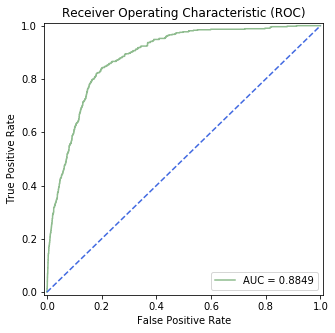

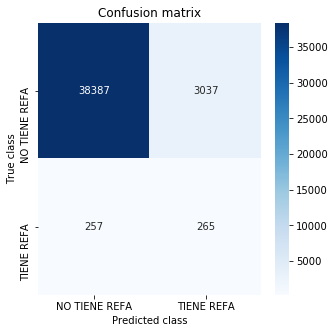

Recall: 0.5077
Precision: 0.0803
F1-score: 0.1386
G-mean: 0.6859
F-measure: 0.5847
AUCM = 0.37261


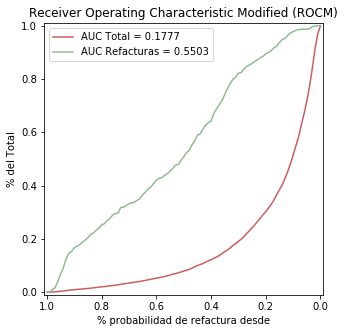

Porcentaje de Refacturas revisadas en limite de analista (3500) es 52.30% con un total de 3451 registros a revisar con el umbral de desicion 49.00
El umbral optimo de revision es 0.47% con un total de 3747 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:20.039066 

Sector de facturacion 02


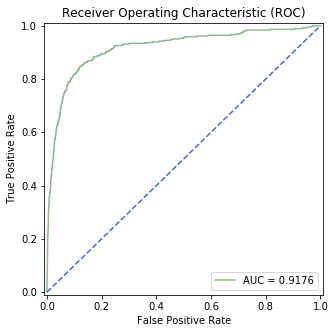

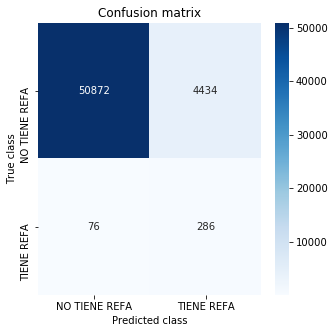

Recall: 0.7901
Precision: 0.0606
F1-score: 0.1126
G-mean: 0.8525
F-measure: 0.8307
AUCM = 0.53636


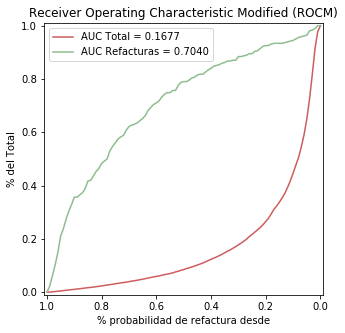

Porcentaje de Refacturas revisadas en limite de analista (3500) es 71.82% con un total de 3395 registros a revisar con el umbral de desicion 59.00
El umbral optimo de revision es 0.63% con un total de 2934 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:24.391678 

Sector de facturacion 03


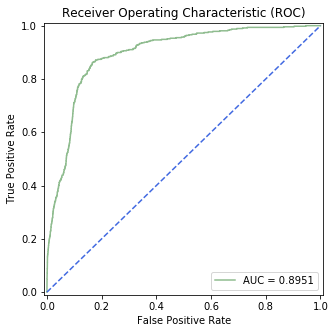

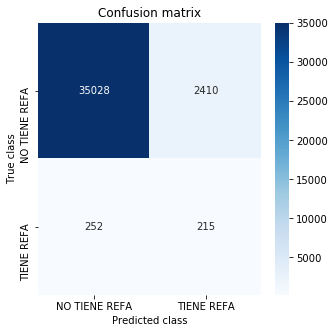

Recall: 0.4604
Precision: 0.0819
F1-score: 0.1391
G-mean: 0.6563
F-measure: 0.5356
AUCM = 0.38623


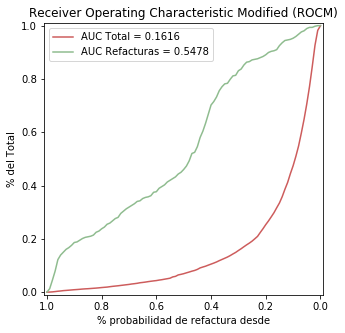

Porcentaje de Refacturas revisadas en limite de analista (3500) es 58.03% con un total de 3446 registros a revisar con el umbral de desicion 44.00
El umbral optimo de revision es 0.45% con un total de 3235 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:14.967521 

Sector de facturacion 04


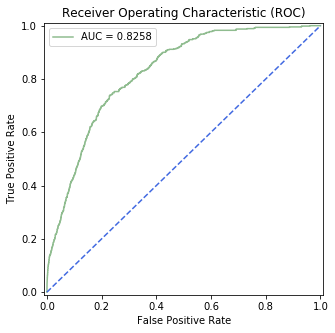

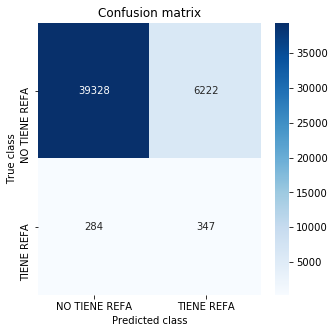

Recall: 0.5499
Precision: 0.0528
F1-score: 0.0964
G-mean: 0.6891
F-measure: 0.5986
AUCM = 0.33957


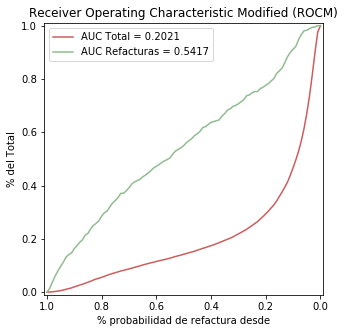

Porcentaje de Refacturas revisadas en limite de analista (3500) es 34.39% con un total de 3369 registros a revisar con el umbral de desicion 75.00
El umbral optimo de revision es 0.44% con un total de 7425 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:18.769245 

Sector de facturacion 05


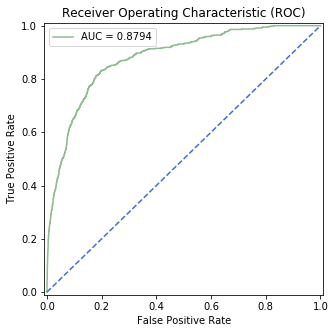

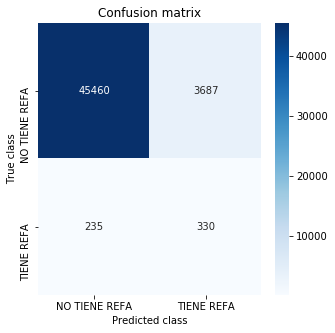

Recall: 0.5841
Precision: 0.0822
F1-score: 0.1440
G-mean: 0.7350
F-measure: 0.6653
AUCM = 0.40556


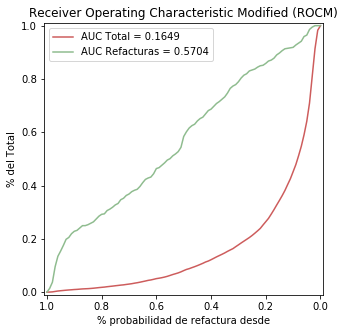

Porcentaje de Refacturas revisadas en limite de analista (3500) es 51.86% con un total de 3434 registros a revisar con el umbral de desicion 53.00
El umbral optimo de revision es 0.50% con un total de 4017 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:20.639587 

Sector de facturacion 06


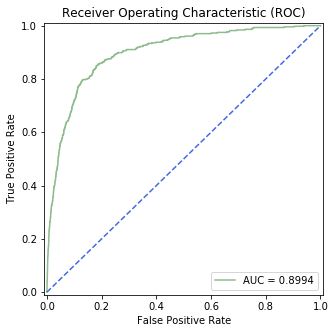

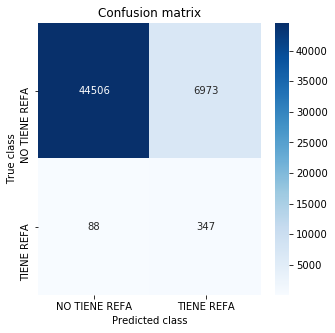

Recall: 0.7977
Precision: 0.0474
F1-score: 0.0895
G-mean: 0.8305
F-measure: 0.7994
AUCM = 0.47802


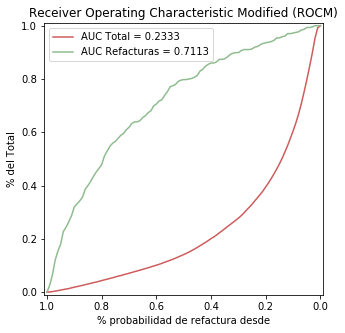

Porcentaje de Refacturas revisadas en limite de analista (3500) es 59.54% con un total de 3398 registros a revisar con el umbral de desicion 72.00
El umbral optimo de revision es 0.61% con un total de 5086 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:22.967659 

Sector de facturacion 07


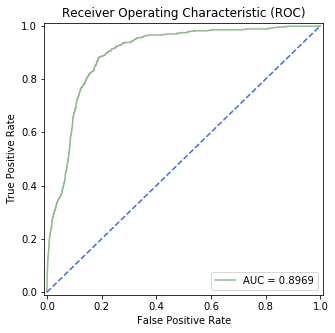

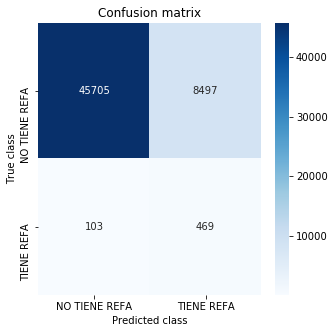

Recall: 0.8199
Precision: 0.0523
F1-score: 0.0983
G-mean: 0.8315
F-measure: 0.8336
AUCM = 0.48627


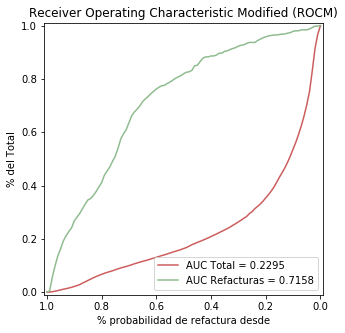

Porcentaje de Refacturas revisadas en limite de analista (3500) es 39.51% con un total de 3440 registros a revisar con el umbral de desicion 81.00
El umbral optimo de revision es 0.62% con un total de 6825 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:19.352312 

Sector de facturacion 08


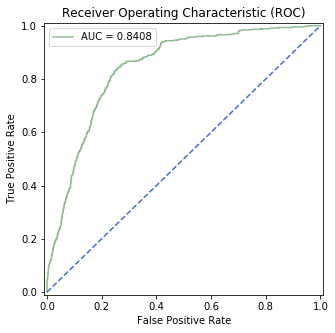

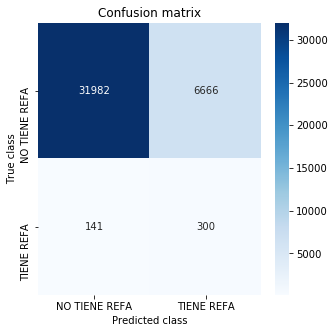

Recall: 0.6803
Precision: 0.0431
F1-score: 0.0810
G-mean: 0.7503
F-measure: 0.6905
AUCM = 0.38416


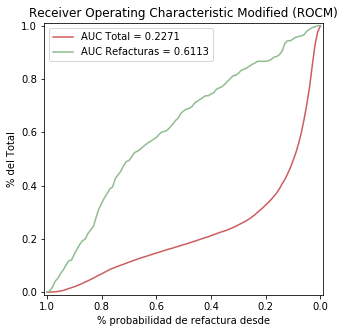

Porcentaje de Refacturas revisadas en limite de analista (3500) es 39.46% con un total de 3492 registros a revisar con el umbral de desicion 76.00
El umbral optimo de revision es 0.50% con un total de 6966 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:16.491841 

Sector de facturacion 09


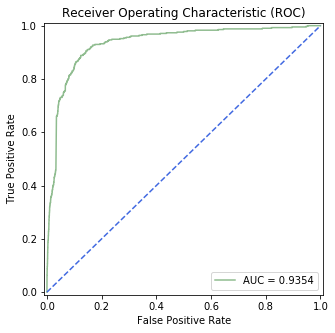

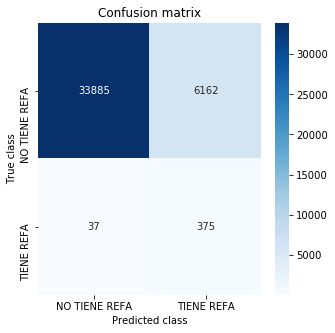

Recall: 0.9102
Precision: 0.0574
F1-score: 0.1079
G-mean: 0.8776
F-measure: 0.9231
AUCM = 0.55001


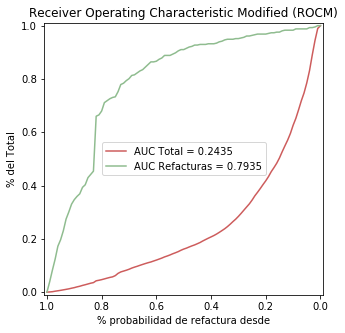

Porcentaje de Refacturas revisadas en limite de analista (3500) es 80.10% con un total de 3470 registros a revisar con el umbral de desicion 70.00
El umbral optimo de revision es 0.71% con un total de 3323 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:19.458725 

Sector de facturacion 10


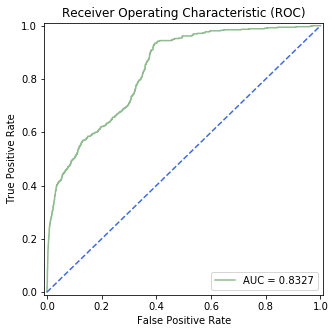

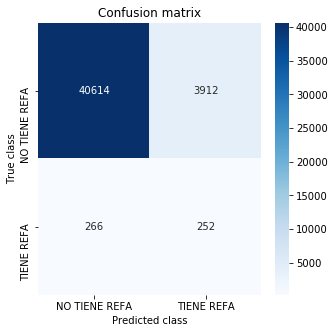

Recall: 0.4865
Precision: 0.0605
F1-score: 0.1076
G-mean: 0.6661
F-measure: 0.5470
AUCM = 0.33718


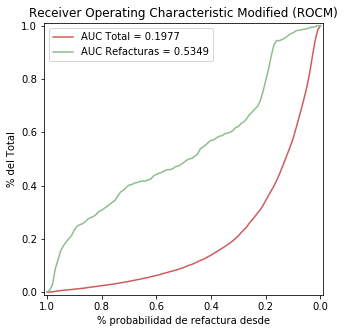

Porcentaje de Refacturas revisadas en limite de analista (3500) es 45.95% con un total de 3460 registros a revisar con el umbral de desicion 55.00
El umbral optimo de revision es 0.43% con un total de 5533 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:19.343815 

Sector de facturacion 11


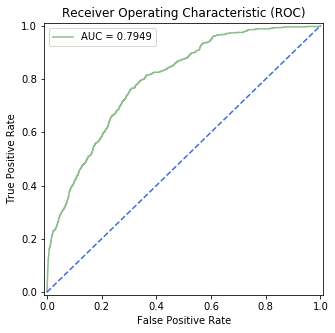

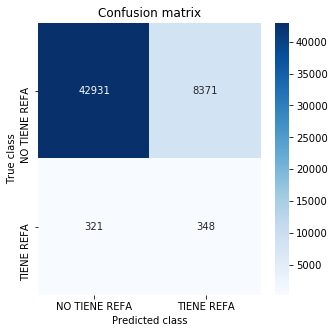

Recall: 0.5202
Precision: 0.0399
F1-score: 0.0741
G-mean: 0.6598
F-measure: 0.5470
AUCM = 0.30684


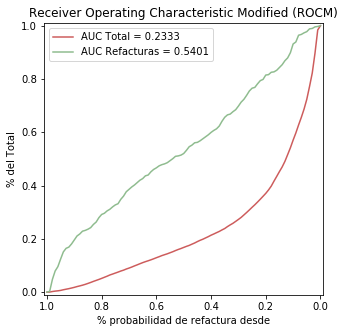

Porcentaje de Refacturas revisadas en limite de analista (3500) es 31.09% con un total de 3346 registros a revisar con el umbral de desicion 77.00
El umbral optimo de revision es 0.39% con un total de 11342 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:25.924740 

Sector de facturacion 12


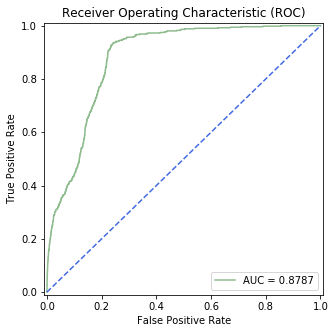

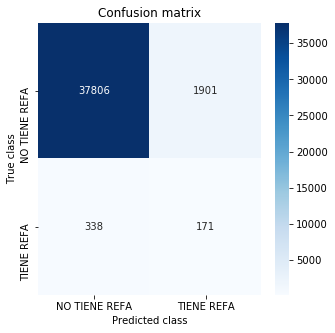

Recall: 0.3360
Precision: 0.0825
F1-score: 0.1325
G-mean: 0.5656
F-measure: 0.3998
AUCM = 0.30874


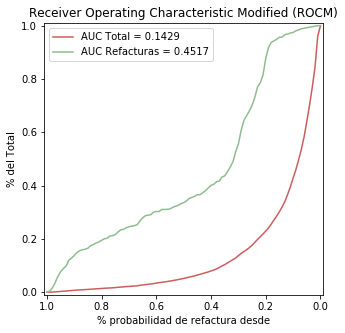

Porcentaje de Refacturas revisadas en limite de analista (3500) es 40.47% con un total de 3335 registros a revisar con el umbral de desicion 39.00
El umbral optimo de revision es 0.34% con un total de 4407 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:20.042385 

Sector de facturacion 13


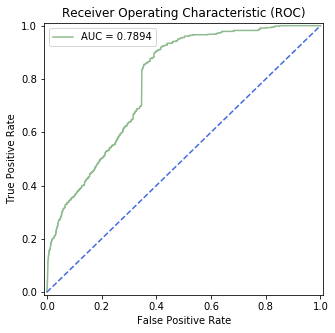

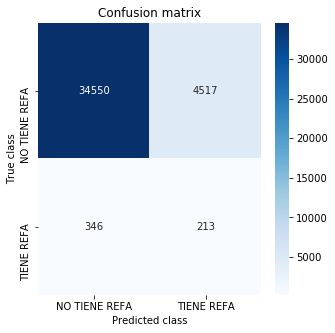

Recall: 0.3810
Precision: 0.0450
F1-score: 0.0805
G-mean: 0.5805
F-measure: 0.4259
AUCM = 0.25446


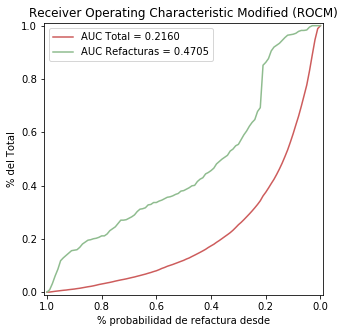

Porcentaje de Refacturas revisadas en limite de analista (3500) es 34.17% con un total de 3339 registros a revisar con el umbral de desicion 59.00
El umbral optimo de revision es 0.31% con un total de 9598 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:21.277388 

Sector de facturacion 14


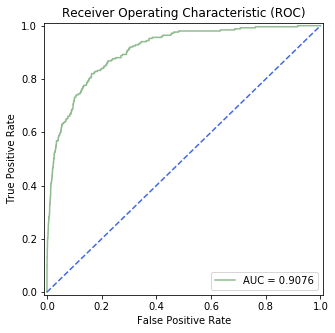

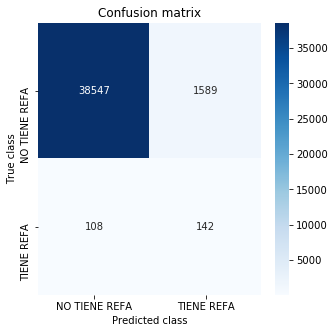

Recall: 0.5680
Precision: 0.0820
F1-score: 0.1434
G-mean: 0.7386
F-measure: 0.6487
AUCM = 0.43886


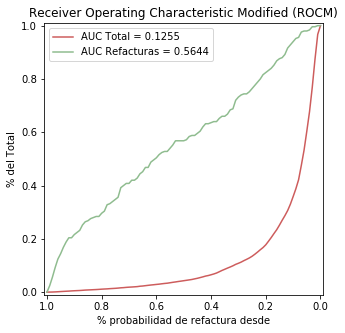

Porcentaje de Refacturas revisadas en limite de analista (3500) es 66.00% con un total de 3462 registros a revisar con el umbral de desicion 35.00
El umbral optimo de revision es 0.53% con un total de 1545 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:20.349551 

Sector de facturacion 15


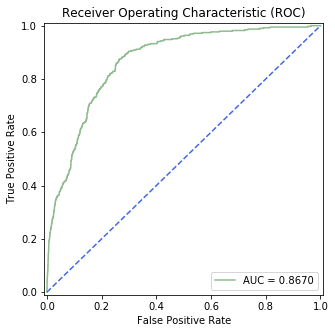

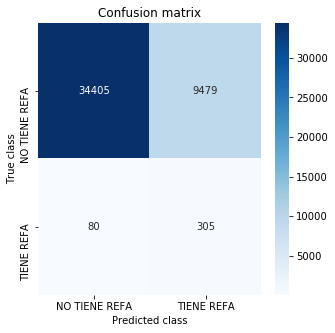

Recall: 0.7922
Precision: 0.0312
F1-score: 0.0600
G-mean: 0.7881
F-measure: 0.7177
AUCM = 0.43514


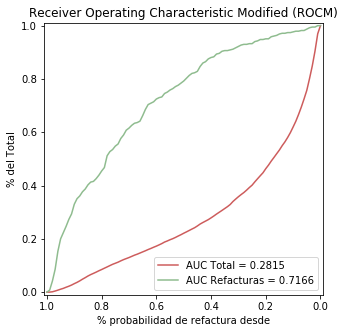

Porcentaje de Refacturas revisadas en limite de analista (3500) es 42.60% con un total de 3325 registros a revisar con el umbral de desicion 82.00
El umbral optimo de revision es 0.56% con un total de 8499 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:20.349537 

Sector de facturacion 16


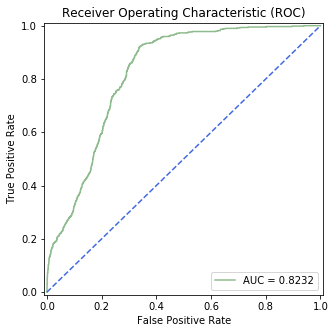

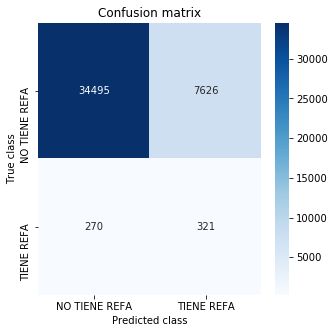

Recall: 0.5431
Precision: 0.0404
F1-score: 0.0752
G-mean: 0.6669
F-measure: 0.5681
AUCM = 0.32105


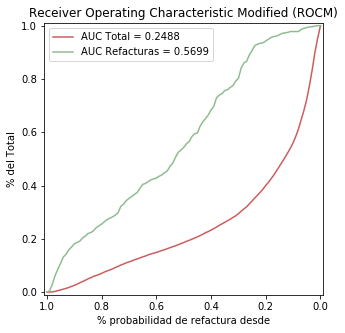

Porcentaje de Refacturas revisadas en limite de analista (3500) es 27.24% con un total de 3401 registros a revisar con el umbral de desicion 78.00
El umbral optimo de revision es 0.43% con un total de 9289 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:20.949401 

Sector de facturacion 17


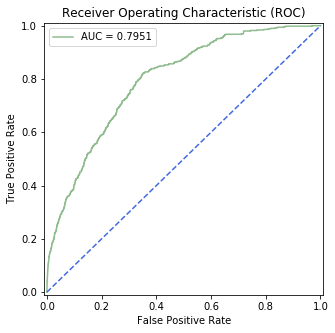

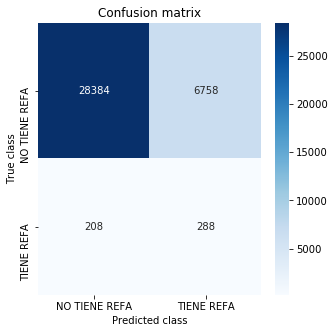

Recall: 0.5806
Precision: 0.0409
F1-score: 0.0764
G-mean: 0.6848
F-measure: 0.6014
AUCM = 0.31935


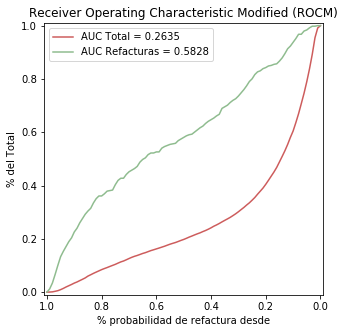

Porcentaje de Refacturas revisadas en limite de analista (3500) es 38.10% con un total de 3435 registros a revisar con el umbral de desicion 77.00
El umbral optimo de revision es 0.41% con un total de 8417 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:17.671304 

Sector de facturacion 18


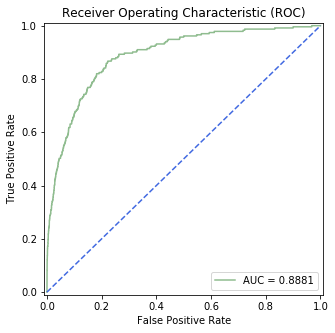

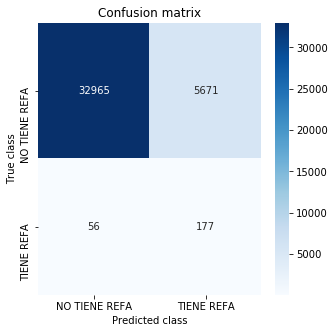

Recall: 0.7597
Precision: 0.0303
F1-score: 0.0582
G-mean: 0.8051
F-measure: 0.6906
AUCM = 0.49154


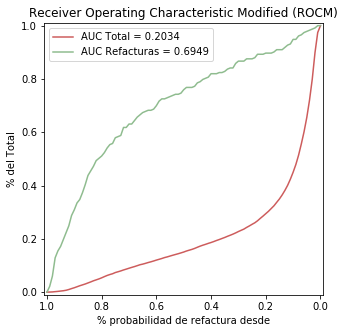

Porcentaje de Refacturas revisadas en limite de analista (3500) es 63.09% con un total de 3486 registros a revisar con el umbral de desicion 70.00
El umbral optimo de revision es 0.59% con un total de 4788 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:18.019254 

Sector de facturacion 19


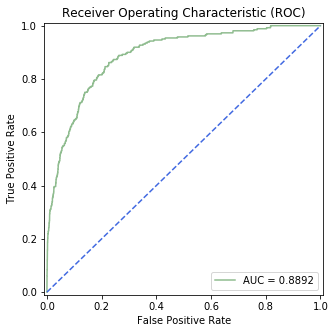

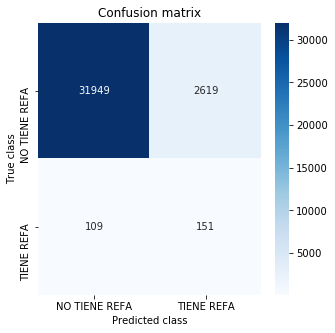

Recall: 0.5808
Precision: 0.0545
F1-score: 0.0997
G-mean: 0.7326
F-measure: 0.6301
AUCM = 0.42533


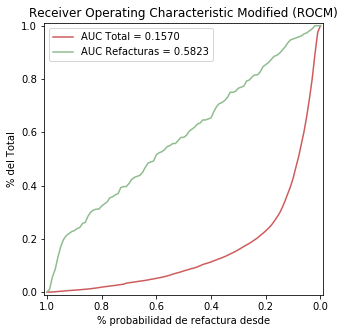

Porcentaje de Refacturas revisadas en limite de analista (3500) es 63.46% con un total de 3449 registros a revisar con el umbral de desicion 44.00
El umbral optimo de revision es 0.51% con un total de 2649 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:16.550002 

Sector de facturacion 20


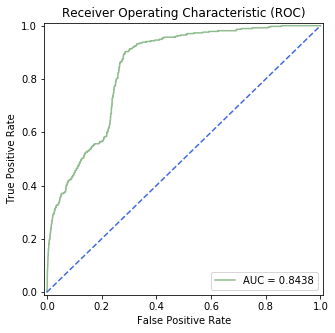

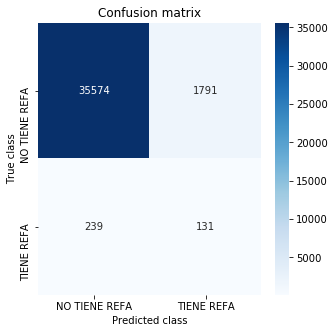

Recall: 0.3541
Precision: 0.0682
F1-score: 0.1143
G-mean: 0.5806
F-measure: 0.4145
AUCM = 0.29075


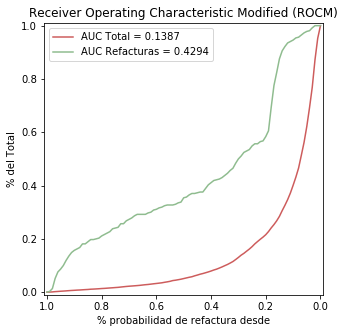

Porcentaje de Refacturas revisadas en limite de analista (3500) es 42.43% con un total de 3406 registros a revisar con el umbral de desicion 37.00
El umbral optimo de revision es 0.34% con un total de 3917 registros a revisar.
Time elapsed (hh:mm:ss.ms) 0:00:17.665315 

Time elapsed (hh:mm:ss.ms) 0:06:35.231259


In [5]:
start_time_tot = datetime.now()
start_time = datetime.now()
#crear variables para guardar resultados
recall = np.zeros(20)
precision = np.zeros(20)
f1_score = np.zeros(20)
g_mean = np.zeros(20)
f_beta = np.zeros(20)
AUCM = np.zeros(20)
umbral_limite = np.zeros(20)
refa_5analistas = np.zeros(20)
limite_5analistas = np.zeros(20)
maxima_diff = np.zeros(20)
maxima_diff_reg = np.zeros(20)
sector = np.zeros(20)
tiempos = np.zeros(20)

ohe = joblib.load('../ohe.pkl')
mini = joblib.load('../mini.pkl')
maxi = joblib.load('../maxi.pkl')
SS = joblib.load('../SS.pkl')
SS_num = joblib.load('../SS_num.pkl')
le = joblib.load('../le.pkl')

#columnas para crear luego el dataframe con los resultados
columns_resultados = ['sector', 'recall', 'precision', 'f1_score', 'g_mean', 'f_beta', 'AUCM', 'umbral_limite', 'refa_5analistas',
                     'limite_5analistas', 'maxima_diff', 'maxima_diff_reg', 'tiempos']
#paarametros de algunas metricas
umbral = 0.5
beta = 8
LABELS = ["NO TIENE REFA","TIENE REFA"]

# sectores para iterar
sectores = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

#codigo diametro
diametros = ['small', 'big']

w = 0
for sec in sectores:
    start_time = datetime.now()
    print('Sector de facturacion ' + sec)
    Data_test = Data_test1.drop(Data_test1[Data_test1['RECORR1']!=sec].index)
    
    predprob_y = np.array([])
    y_test = np.array([])
    for diametro in diametros:
        if diametro == 'small':
            Data_test_cod = Data_test.drop(Data_test[(Data_test['COD_DIAMETRO']=='050') | (Data_test['COD_DIAMETRO']=='075') | (Data_test['COD_DIAMETRO']=='100') | (Data_test['COD_DIAMETRO']=='150') | (Data_test['COD_DIAMETRO']=='200')].index)
        if diametro == 'big':
            Data_test_cod = Data_test.drop(Data_test[(Data_test['COD_DIAMETRO']=='013') | (Data_test['COD_DIAMETRO']=='019') | (Data_test['COD_DIAMETRO']=='025') | (Data_test['COD_DIAMETRO']=='032') | (Data_test['COD_DIAMETRO']=='038')].index)
        
        if len(Data_test_cod) != 0:
            # predicciones
            x_test, y_test_cod = Preprocesamiento_Datos(Data_test_cod, splits=False,
                                                        ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le, verbose=0)
            
            # load the model from disk
            filename = 'modelo_XGB_DNA_diametro_' + str(diametro) + '.sav'
            model_XGB = joblib.load(filename)
            
            predprob_y = np.append(predprob_y, model_XGB.predict_proba(x_test.tocsr())[:,1])
            y_test = np.append(y_test, y_test_cod)
    
    #guardo probabilidades de predicciones
    joblib.dump(predprob_y, 'predprob_y_XGB.pkl')
     
    # grafica ROC
    fpr, tpr, threshold = metrics.roc_curve(y_test, predprob_y)
    roc_auc = metrics.auc(fpr, tpr)
    curva_ROC(fpr, tpr, roc_auc)
    
    # matriz de confusion y metricas
    predprob_y = joblib.load('predprob_y_XGB.pkl')
    mostrar_resultados(y_test=y_test, pred_y=predprob_y, umbral=umbral)
    recall[w], precision[w], f1_score[w], g_mean[w], f_beta[w] = MOSTRAR_METRICAS(y_test=y_test, pred_y=predprob_y,
                                                                                  umbral=umbral, beta=beta)
    
    # ROCM y datos
    umbral_limite[w], refa_5analistas[w], limite_5analistas[w], maxima_diff[w], maxima_diff_reg[w], AUCM[w] = AUCM_PLOT('predprob_y_XGB.pkl')
    print('Porcentaje de Refacturas revisadas en limite de analista (3500) es %0.2f' % (refa_5analistas[w]*100) + '% ' +
          'con un total de %i' % limite_5analistas[w] + ' registros a revisar con el umbral de desicion %0.2f' % (umbral_limite[w]*100))
    print('El umbral optimo de revision es %0.2f' % maxima_diff[w] + '% ' + 'con un total de %i' % maxima_diff_reg[w] + ' registros a revisar.')
    
    #se muestran y se guardan tiempos de prediccion en cada sector
    print('Time elapsed (hh:mm:ss.ms) {} \n'.format(datetime.now() - start_time))
    tiempos[w] = ((datetime.now() - start_time).seconds) / 60  #en minutos
    
    #iterador
    w = w + 1
    
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time_tot))

In [6]:
# guardar resultados de cada sector en archivo csv
matriz_resultados = np.vstack((sector, recall, precision, f1_score, g_mean, f_beta, AUCM, umbral_limite, refa_5analistas,
                              limite_5analistas, maxima_diff, maxima_diff_reg, tiempos))
matriz_resultados = np.transpose(matriz_resultados)

Data_resultados =  pd.DataFrame(data=matriz_resultados, columns=columns_resultados)

Data_resultados.to_csv('Data_resultados_sectores_DIC18_XGB.csv', sep=';', header=True, float_format='%.4f', encoding='utf-8')
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:17.710990


In [7]:
# load the model from disk
#decision_tree = joblib.load('model_DT_V2.sav')